## The Image Classification Dataset

One of the widely used dataset for image classification is the MNIST dataset [LeCun et al., 1998]. While it had a good run as a benchmark dataset, even simple models by today’s standards achieve classification accuracy over 95%, making it unsuitable for distinguishing between stronger models and weaker ones. Today, MNIST serves as more of sanity checks than as a benchmark. To up the ante just a bit, we will focus our discussion in the coming sections on the qualitatively similar, but comparatively complex Fashion-MNIST dataset [Xiao et al., 2017], which was released in 2017.

In [1]:
!pip install torch torchvision

In [3]:
!pip install -U d2l

In [5]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

## Reading the Dataset

In [6]:
# `ToTensor` converts the image data from PIL type to 32-bit floating point
# tensors. It divides all numbers by 255 so that all pixel values are between
# 0 and 1
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



**Fashion-MNIST** consists of images from 10 categories, each represented by 6000 images in the training dataset and by 1000 in the test dataset. A test dataset (*or test set*) is used for evaluating model performance and not for training. Consequently the training set and the test set contain 60000 and 10000 images, respectively.

In [7]:
len(mnist_train), len(mnist_test)

(60000, 10000)

**The images in Fashion-MNIST** are associated with the following **categories**: t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot. **The following function converts between numeric label indices and their names in text**.

In [9]:
def get_fashion_mnist_labels(labels):  #save
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [11]:
# We can now create a function to visualize these examples.

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [ ]:
# Here are the images and their corresponding labels (in text) for the first few examples in the training dataset.

X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

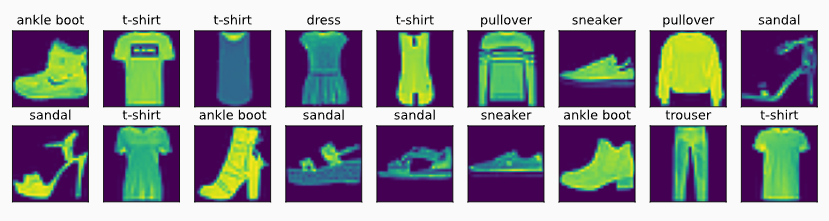

##  Reading a Minibatch

To make our life easier when reading from the training and test sets, we use the built-in data iterator rather than creating one from scratch. **Recall that at each iteration**, a data iterator reads a minibatch of data with size **batch_size** each time. We also randomly shuffle the examples for the training data iterator.

In [14]:
batch_size = 256

def get_dataloader_workers():  #save
    """Use 4 processes to read the data."""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
# Let us look at the time it takes to read the training data.

timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


'5.32 sec'

## Putting All Things Together

Now we define the **load_data_fashion_mnist** function that **obtains and reads the Fashion-MNIST dataset**. It returns the data iterators for both the training set and validation set. In addition, it accepts an optional argument to resize images to another shape.

In [17]:
def load_data_fashion_mnist(batch_size, resize=None):  #save
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

Below we test the image resizing feature of the **load_data_fashion_mnist** function by specifying the **resize** argument.

In [18]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## Summary



*   Fashion-MNIST is an apparel classification dataset consisting of images representing 10 categories. We will use this dataset in subsequent sections and chapters to evaluate various classification algorithms.
*   We store the shape of any image with height **h** width **w** pixels as **h x w** or (**h, w**)
*   Data iterators are a key component for efficient performance. Rely on well-implemented data iterators that exploit high-performance computing to avoid slowing down your training loop.


